In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 7, 4

from importlib import reload
from collections import Counter

import plotting
import toolbox as tb
import feature_creation

# reload modules
tb = reload(tb)
plotting = reload(plotting)
feature_creation = reload(feature_creation)

from plotting import Plotter

from feature_creation import YNormal, featurize, my_get_dummies

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

Load data.

In [140]:
train_data = pd.read_csv('dataset/train.csv')
validation = pd.read_csv('dataset/validation.csv')
test_data = pd.read_csv('dataset/test.csv')

train_data.shape, validation.shape, test_data.shape

((2250, 24), (750, 24), (4398, 22))

In [141]:
train_data.head()

,Unnamed: 0,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,750,751,NaN,30000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0332047,en,Fever Pitch,When relaxed and charming Ben Wrightman meets ...,...,4/6/05,103.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Comedy About The Game of Love.,Fever Pitch,"[{'id': 1480, 'name': 'baseball'}, {'id': 3419...","[{'cast_id': 1, 'character': 'Lindsey Meeks', ...","[{'credit_id': '52fe443f9251416c7502df99', 'de...",50451307
1,751,752,"[{'id': 5039, 'name': 'Rambo Collection', 'pos...",50000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.rambofilm.com/,tt0462499,en,Rambo,When governments fail to act on behalf of capt...,...,1/24/08,92.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heroes never die... They just reload.,Rambo,"[{'id': 440, 'name': 'missionary'}, {'id': 126...","[{'cast_id': 12, 'character': 'John Rambo', 'c...","[{'credit_id': '55c8e0ff92514177c9000085', 'de...",113244290
2,752,753,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 99, 'nam...",NaN,tt0175844,en,Lenny Bruce: Swear to Tell the Truth,"In 1948, Lenny Bruce was just another comic wh...",...,10/21/98,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A documentary about the comic who invented con...,Lenny Bruce: Swear to Tell the Truth,"[{'id': 3485, 'name': 'comedian'}, {'id': 5565...","[{'cast_id': 1, 'character': 'Himself / Narrat...","[{'credit_id': '52fe4a19c3a36847f81b92ff', 'de...",21350
3,753,754,"[{'id': 59586, 'name': 'The Blue Lagoon collec...",4500000,"[{'id': 10749, 'name': 'Romance'}, {'id': 12, ...",NaN,tt0080453,en,The Blue Lagoon,Two small children and a ship's cook survive a...,...,7/5/80,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A sensuous story of natural love.,The Blue Lagoon,"[{'id': 566, 'name': 'sexual identity'}, {'id'...","[{'cast_id': 7, 'character': 'Emmeline', 'cred...","[{'credit_id': '52fe4418c3a36847f8081fa3', 'de...",58853106
4,754,755,NaN,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.paramountvantage.com/virginsuicides...,tt0159097,en,The Virgin Suicides,A group of male friends become obsessed with f...,...,4/21/99,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Beautiful, mysterious, haunting, invariably fa...",The Virgin Suicides,"[{'id': 933, 'name': 'michigan'}, {'id': 1228,...","[{'cast_id': 17, 'character': 'Mr. Lisbon', 'c...","[{'credit_id': '52fe42f8c3a36847f80308d5', 'de...",10409377


In [142]:
train_data.columns

Index(['Unnamed: 0', 'id', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

Make a copy of *train_data* and *test_data* for not modifing them.

In [143]:
train_df = train_data.copy()
test_df = test_data.copy()

# checking the ids
np.any((id(train_df) == id(train_data)) and (id(test_df) == id(test_data)))

False

In [144]:
plotter = Plotter(colors=['red', 'blue', 'green', 'orange'])

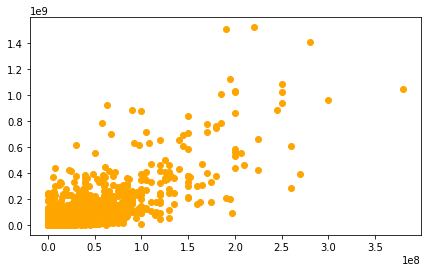

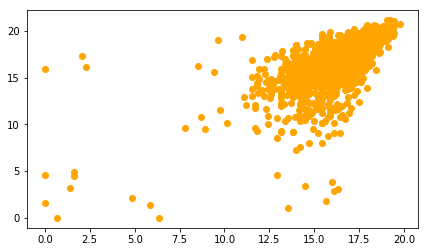

In [145]:
plt.scatter(train_df['budget'], train_df['revenue'], color='orange')
plt.show()
plt.scatter(np.log(train_df['budget'].fillna(0)), np.log(train_df['revenue'].fillna(0)), color='orange')
plt.show()

In [146]:
years = np.array([date[-2:] for date in train_data.release_date.values])
unique_years, years_counts = np.unique(years, return_counts=True)

years_, sums = np.array(list(tb.get_unique_values(years, train_df.revenue, oper=np.mean))).T

sorted(list(tb.get_unique_values(years, train_df.revenue, oper=np.mean)), key=lambda x: x[1], reverse=True)[:10]

[('15', 10358282578),
 ('12', 9601960200),
 ('11', 8141855434),
 ('13', 8123090217),
 ('14', 7366063155),
 ('10', 7162874268),
 ('08', 7120057657),
 ('09', 6424480681),
 ('16', 6364018980),
 ('07', 6090500321)]

In [147]:
unique_years[np.argsort(years_counts)[::-1]]

array(['13', '15', '10', '11', '14', '16', '12', '06', '08', '07', '09',
       '05', '02', '04', '01', '03', '00', '98', '99', '97', '96', '95',
       '89', '93', '88', '87', '94', '85', '90', '91', '86', '92', '17',
       '84', '83', '81', '80', '82', '79', '78', '73', '72', '77', '71',
       '64', '70', '75', '48', '55', '60', '74', '66', '67', '63', '53',
       '76', '39', '68', '45', '59', '36', '42', '51', '69', '61', '62',
       '54', '58', '57', '43', '50', '25', '65', '27', '28', '32', '47',
       '31', '49', '56', '21', '26', '30', '33', '35', '38', '40', '44',
       '24'], dtype='<U2')

In [148]:
full_years = np.array([f'20{year[-2:]}' if year[-2:].startswith('0') else f'19{year[-2:]}'
                       for year in years_], dtype=np.int)

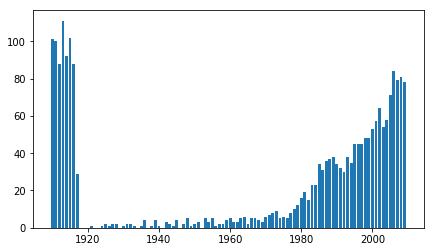

In [149]:
plt.bar(full_years, years_counts)
plt.show()

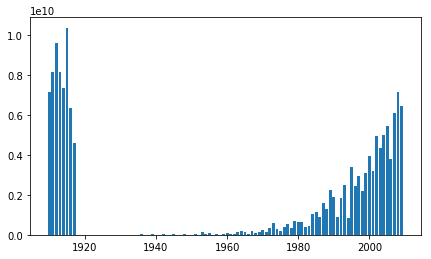

In [150]:
plt.bar(full_years, sums.astype(np.int))
plt.show()

In [151]:
train_df.production_companies.iloc[0]

"[{'name': 'Fox 2000 Pictures', 'id': 711}, {'name': 'Wildgaze Films', 'id': 1508}, {'name': 'Alan Greenspan Productions', 'id': 6401}, {'name': 'Mars Media Beteiligungs', 'id': 6402}, {'name': 'Flower Films (II)', 'id': 19813}, {'name': 'ELC Productions Ltd.', 'id': 73953}]"

In [152]:
json_prod_com = tb.json_to_dict(train_df.production_companies.fillna(''))
tb.get_json_features(json_prod_com, 'name', train_df.revenue)[:10]

[('Warner Bros.', 19216337649),
 ('Paramount Pictures', 16072796429),
 ('Universal Pictures', 15867755667),
 ('Walt Disney Pictures', 13414908437),
 ('Twentieth Century Fox Film Corporation', 11836503410),
 ('Columbia Pictures', 9224099662),
 ('New Line Cinema', 6530786092),
 ('Legendary Pictures', 5521570363),
 ('Marvel Studios', 5292772946),
 ('Revolution Sun Studios', 5243755063)]

In [153]:
company_names = [dict['name'] for dicts in json_prod_com for dict in dicts]
Counter(company_names).most_common()[:10]

[('Warner Bros.', 149),
 ('Universal Pictures', 139),
 ('Paramount Pictures', 121),
 ('Twentieth Century Fox Film Corporation', 107),
 ('Columbia Pictures', 73),
 ('Metro-Goldwyn-Mayer (MGM)', 64),
 ('New Line Cinema', 56),
 ('Walt Disney Pictures', 47),
 ('Columbia Pictures Corporation', 46),
 ('Relativity Media', 40)]

In [154]:
train_df['production_companies'].iloc[0]

"[{'name': 'Fox 2000 Pictures', 'id': 711}, {'name': 'Wildgaze Films', 'id': 1508}, {'name': 'Alan Greenspan Productions', 'id': 6401}, {'name': 'Mars Media Beteiligungs', 'id': 6402}, {'name': 'Flower Films (II)', 'id': 19813}, {'name': 'ELC Productions Ltd.', 'id': 73953}]"

In [155]:
json_prod_count = tb.json_to_dict(train_df.production_countries.fillna(''))
tb.get_json_features(json_prod_count, 'name', train_df.revenue)[:10]

[('United States of America', 140616778685),
 ('United Kingdom', 21828233674),
 ('Germany', 8068229931),
 ('Canada', 7692172643),
 ('France', 5255328343),
 ('China', 3135772041),
 ('Australia', 2685650159),
 ('Japan', 2593708596),
 ('New Zealand', 2389570648),
 ('Hong Kong', 2079695185)]

In [156]:
country_names = [dict['name'] for dicts in json_prod_com for dict in dicts]
Counter(country_names).most_common()[:10]

[('Warner Bros.', 149),
 ('Universal Pictures', 139),
 ('Paramount Pictures', 121),
 ('Twentieth Century Fox Film Corporation', 107),
 ('Columbia Pictures', 73),
 ('Metro-Goldwyn-Mayer (MGM)', 64),
 ('New Line Cinema', 56),
 ('Walt Disney Pictures', 47),
 ('Columbia Pictures Corporation', 46),
 ('Relativity Media', 40)]

In [157]:
train_df.cast.iloc[0][:202]

"[{'cast_id': 1, 'character': 'Lindsey Meeks', 'credit_id': '52fe443f9251416c7502df43', 'gender': 1, 'id': 69597, 'name': 'Drew Barrymore', 'order': 0, 'profile_path': '/y8GKPHsBXVGIGBdDzdNxjm0IbKF.jpg'}"

In [158]:
all_actors = [dict['name'] for dicts in tb.json_to_dict(train_df.cast.fillna('')) for dict in dicts]
Counter(all_actors).most_common(10)

[('Robert De Niro', 26),
 ('Samuel L. Jackson', 26),
 ('Morgan Freeman', 23),
 ('Willem Dafoe', 20),
 ('John Goodman', 20),
 ('Bruce Willis', 19),
 ('Robert Duvall', 18),
 ('Liam Neeson', 18),
 ('Forest Whitaker', 18),
 ('Susan Sarandon', 17)]

In [159]:
cast_json = tb.json_to_dict(train_df.cast.fillna(''))
tb.get_json_features(cast_json, 'name', train_df.revenue)[:10]

[('Samuel L. Jackson', 7316018488),
 ('Stan Lee', 6518945480),
 ('Frank Welker', 4982007905),
 ('Jeremy Renner', 4643068839),
 ('Johnny Depp', 4586705934),
 ('Tyrese Gibson', 4410059212),
 ('Judi Dench', 4317926509),
 ('Stellan Skarsg√•rd', 4149023692),
 ('John Turturro', 4140831341),
 ('Shia LaBeouf', 4090590413)]

In [160]:
train_df.crew.iloc[0][:161]

"[{'credit_id': '52fe443f9251416c7502df99', 'department': 'Production', 'gender': 1, 'id': 1588, 'job': 'Producer', 'name': 'Nancy Juvonen', 'profile_path': None}"

In [161]:
cast_json = tb.json_to_dict(train_df.crew.fillna(''))
tb.get_json_features(cast_json, 'name', train_df.revenue)[:10]

[('Christopher Boyes', 13147223385),
 ('Stan Lee', 9758137257),
 ('Steven Spielberg', 9659724469),
 ('Joss Whedon', 8127843510),
 ('Michael Bay', 8069348053),
 ('Sarah Finn', 7880046929),
 ('Luca Marco Paracels', 7669512295),
 ('Brian N. Bentley', 7443764112),
 ('Hans Zimmer', 6711791961),
 ('James Newton Howard', 6550868848)]

In [162]:
all_crew_members = [dict['name'] for dicts in tb.json_to_dict(train_df.crew.fillna('')) for dict in dicts]
Counter(all_crew_members).most_common(10)

[('Avy Kaufman', 38),
 ('Steven Spielberg', 33),
 ('Luc Besson', 31),
 ('Deborah Aquila', 30),
 ('James Newton Howard', 29),
 ('James Horner', 28),
 ('Tricia Wood', 27),
 ('Francine Maisler', 26),
 ('Jerry Goldsmith', 26),
 ('Kerry Barden', 26)]

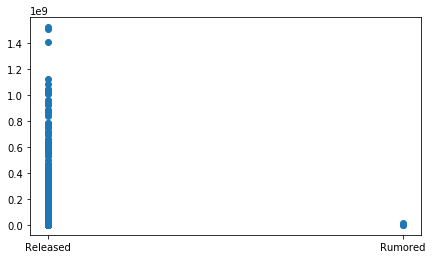

In [163]:
plt.scatter(train_df.status, train_df.revenue)

The bigger crew the higher revenue.

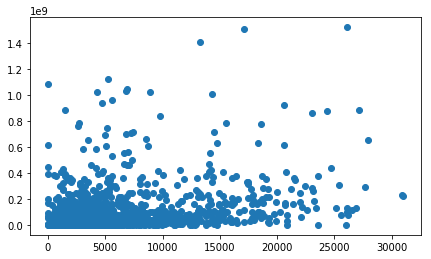

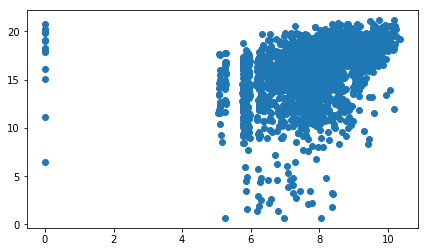

In [164]:
crew_count = train_df.crew.fillna('').apply(lambda x: len(x) if x != dict() else 0)

plt.scatter(crew_count, train_df.revenue)
plt.show()

plt.scatter(np.log1p(crew_count), np.log1p(train_df.revenue))
plt.show()

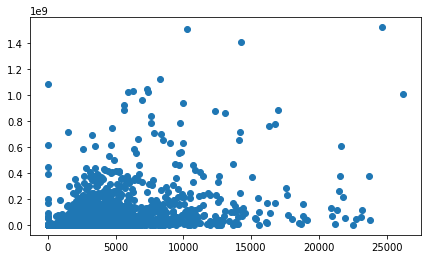

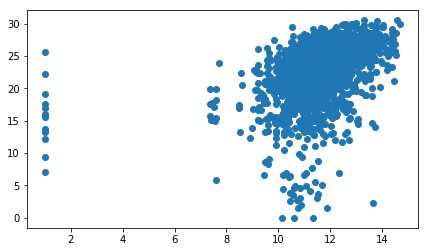

In [166]:
cast_count = train_df.cast.fillna('').apply(lambda x: len(x) if x != dict() else 0)

plt.scatter(cast_count, train_df.revenue)
plt.show()

plt.scatter(np.log2(cast_count), np.log2(train_df.revenue))
plt.show()

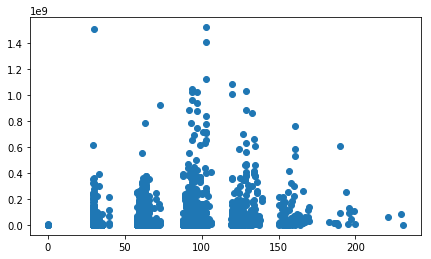

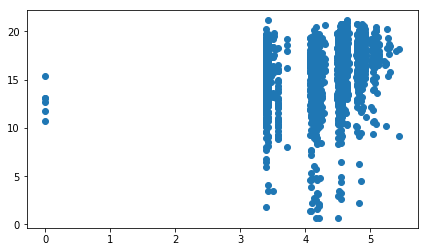

In [169]:
genres_count = train_df.genres.fillna('').apply(lambda x: len(x) if x != dict() else 0)

plt.scatter(genres_count, train_df.revenue)
plt.show()

plt.scatter(np.log1p(genres_count), np.log1p(train_df.revenue))
plt.show()